In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "z"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.44it/s]

11it [00:00,  4.84it/s]

22it [00:00,  6.78it/s]

30it [00:00,  9.34it/s]

38it [00:00, 12.64it/s]

46it [00:00, 16.79it/s]

54it [00:00, 21.87it/s]

62it [00:01, 27.90it/s]

72it [00:01, 35.53it/s]

84it [00:01, 44.67it/s]

96it [00:01, 54.45it/s]

107it [00:01, 63.62it/s]

118it [00:01, 72.25it/s]

129it [00:01, 80.42it/s]

141it [00:01, 87.63it/s]

152it [00:01, 93.27it/s]

163it [00:01, 91.61it/s]

174it [00:02, 94.30it/s]

185it [00:02, 95.13it/s]

196it [00:02, 97.10it/s]

207it [00:02, 100.49it/s]

218it [00:02, 99.35it/s] 

229it [00:02, 88.99it/s]

241it [00:02, 95.28it/s]

253it [00:02, 100.56it/s]

264it [00:03, 102.86it/s]

275it [00:03, 104.23it/s]

287it [00:03, 106.62it/s]

299it [00:03, 107.63it/s]

311it [00:03, 108.90it/s]

323it [00:03, 110.36it/s]

335it [00:03, 108.39it/s]

346it [00:03, 108.07it/s]

358it [00:03, 109.66it/s]

370it [00:03, 110.39it/s]

382it [00:04, 110.69it/s]

394it [00:04, 111.28it/s]

406it [00:04, 111.74it/s]

418it [00:04, 111.89it/s]

430it [00:04, 109.13it/s]

441it [00:04, 99.68it/s] 

453it [00:04, 103.66it/s]

465it [00:04, 106.48it/s]

477it [00:04, 108.47it/s]

489it [00:05, 110.00it/s]

501it [00:05, 109.88it/s]

513it [00:05, 110.92it/s]

525it [00:05, 111.16it/s]

537it [00:05, 112.05it/s]

549it [00:05, 112.59it/s]

561it [00:05, 101.69it/s]

572it [00:05, 93.04it/s] 

582it [00:05, 94.06it/s]

593it [00:06, 97.83it/s]

605it [00:06, 101.32it/s]

616it [00:06, 91.13it/s] 

626it [00:06, 85.86it/s]

635it [00:06, 80.99it/s]

646it [00:06, 87.00it/s]

657it [00:06, 91.36it/s]

669it [00:06, 96.71it/s]

681it [00:07, 100.62it/s]

693it [00:07, 103.54it/s]

704it [00:07, 105.34it/s]

716it [00:07, 107.11it/s]

728it [00:07, 108.88it/s]

739it [00:07, 109.08it/s]

751it [00:07, 110.26it/s]

763it [00:07, 107.81it/s]

774it [00:07, 104.46it/s]

786it [00:07, 107.04it/s]

797it [00:08, 106.93it/s]

808it [00:08, 106.66it/s]

819it [00:08, 107.54it/s]

831it [00:08, 108.90it/s]

842it [00:08, 108.92it/s]

854it [00:08, 109.80it/s]

866it [00:08, 110.12it/s]

878it [00:08, 110.45it/s]

890it [00:08, 106.07it/s]

902it [00:09, 107.12it/s]

913it [00:09, 106.56it/s]

925it [00:09, 107.64it/s]

937it [00:09, 108.36it/s]

949it [00:09, 109.02it/s]

961it [00:09, 109.43it/s]

972it [00:09, 108.31it/s]

984it [00:09, 109.13it/s]

996it [00:09, 109.46it/s]

1007it [00:10, 107.27it/s]

1019it [00:10, 107.89it/s]

1031it [00:10, 108.76it/s]

1042it [00:10, 96.05it/s] 

1052it [00:10, 95.47it/s]

1063it [00:10, 98.64it/s]

1074it [00:10, 101.50it/s]

1085it [00:10, 103.64it/s]

1097it [00:10, 105.51it/s]

1109it [00:11, 106.88it/s]

1120it [00:11, 107.43it/s]

1131it [00:11, 108.17it/s]

1143it [00:11, 108.82it/s]

1154it [00:11, 101.44it/s]

1165it [00:11, 98.10it/s] 

1175it [00:11, 95.06it/s]

1185it [00:11, 88.64it/s]

1195it [00:11, 91.68it/s]

1206it [00:12, 95.46it/s]

1216it [00:12, 95.99it/s]

1227it [00:12, 99.80it/s]

1239it [00:12, 103.93it/s]

1251it [00:12, 106.74it/s]

1263it [00:12, 108.32it/s]

1275it [00:12, 109.00it/s]

1286it [00:12, 103.99it/s]

1298it [00:12, 106.05it/s]

1309it [00:12, 106.86it/s]

1320it [00:13, 106.85it/s]

1331it [00:13, 104.43it/s]

1342it [00:13, 103.57it/s]

1353it [00:13, 92.70it/s] 

1365it [00:13, 97.69it/s]

1377it [00:13, 101.48it/s]

1388it [00:13, 103.61it/s]

1400it [00:13, 105.77it/s]

1411it [00:13, 106.81it/s]

1423it [00:14, 107.62it/s]

1435it [00:14, 108.93it/s]

1447it [00:14, 109.57it/s]

1458it [00:14, 108.79it/s]

1470it [00:14, 109.38it/s]

1481it [00:14, 106.21it/s]

1493it [00:14, 108.13it/s]

1505it [00:14, 108.96it/s]

1517it [00:14, 110.17it/s]

1529it [00:15, 111.61it/s]

1541it [00:15, 112.19it/s]

1553it [00:15, 112.70it/s]

1565it [00:15, 112.49it/s]

1577it [00:15, 111.87it/s]

1589it [00:15, 104.22it/s]

1601it [00:15, 103.26it/s]

1613it [00:15, 105.87it/s]

1624it [00:15, 102.31it/s]

1635it [00:16, 100.20it/s]

1646it [00:16, 99.70it/s] 

1658it [00:16, 103.04it/s]

1670it [00:16, 105.78it/s]

1682it [00:16, 107.61it/s]

1694it [00:16, 108.81it/s]

1705it [00:16, 106.45it/s]

1717it [00:16, 108.08it/s]

1729it [00:16, 109.82it/s]

1741it [00:17, 100.23it/s]

1752it [00:17, 99.80it/s] 

1764it [00:17, 102.84it/s]

1775it [00:17, 103.93it/s]

1787it [00:17, 106.00it/s]

1798it [00:17, 106.85it/s]

1810it [00:17, 108.01it/s]

1821it [00:17, 101.71it/s]

1833it [00:17, 104.95it/s]

1845it [00:18, 107.24it/s]

1856it [00:18, 107.76it/s]

1867it [00:18, 108.08it/s]

1878it [00:18, 107.44it/s]

1889it [00:18, 100.84it/s]

1901it [00:18, 102.18it/s]

1912it [00:18, 102.30it/s]

1923it [00:18, 103.76it/s]

1934it [00:18, 102.05it/s]

1946it [00:19, 105.20it/s]

1958it [00:19, 107.58it/s]

1969it [00:19, 107.79it/s]

1981it [00:19, 108.81it/s]

1992it [00:19, 109.14it/s]

2004it [00:19, 109.71it/s]

2016it [00:19, 110.47it/s]

2028it [00:19, 110.41it/s]

2040it [00:19, 110.42it/s]

2052it [00:20, 92.30it/s] 

2063it [00:20, 95.99it/s]

2074it [00:20, 99.62it/s]

2085it [00:20, 101.80it/s]

2097it [00:20, 104.28it/s]

2108it [00:20, 105.63it/s]

2119it [00:20, 106.85it/s]

2130it [00:20, 107.46it/s]

2141it [00:20, 106.26it/s]

2152it [00:20, 106.38it/s]

2163it [00:21, 106.92it/s]

2174it [00:21, 105.39it/s]

2185it [00:21, 105.53it/s]

2196it [00:21, 106.12it/s]

2207it [00:21, 106.85it/s]

2218it [00:21, 107.56it/s]

2229it [00:21, 108.00it/s]

2240it [00:21, 108.33it/s]

2252it [00:21, 109.25it/s]

2263it [00:21, 108.96it/s]

2274it [00:22, 108.63it/s]

2286it [00:22, 109.70it/s]

2297it [00:22, 107.30it/s]

2308it [00:22, 105.34it/s]

2319it [00:22, 106.56it/s]

2331it [00:22, 108.47it/s]

2343it [00:22, 109.55it/s]

2354it [00:22, 107.66it/s]

2366it [00:22, 109.89it/s]

2378it [00:23, 110.30it/s]

2390it [00:23, 104.99it/s]

2402it [00:23, 107.09it/s]

2413it [00:23, 107.94it/s]

2424it [00:23, 107.73it/s]

2435it [00:23, 105.41it/s]

2447it [00:23, 107.23it/s]

2459it [00:23, 108.23it/s]

2471it [00:23, 109.42it/s]

2482it [00:24, 109.25it/s]

2494it [00:24, 110.15it/s]

2506it [00:24, 110.44it/s]

2518it [00:24, 109.92it/s]

2529it [00:24, 108.72it/s]

2540it [00:24, 86.82it/s] 

2550it [00:24, 82.97it/s]

2559it [00:24, 75.63it/s]

2570it [00:25, 82.31it/s]

2579it [00:25, 77.60it/s]

2590it [00:25, 84.69it/s]

2601it [00:25, 90.42it/s]

2613it [00:25, 96.00it/s]

2624it [00:25, 96.95it/s]

2635it [00:25, 99.17it/s]

2646it [00:25, 101.59it/s]

2657it [00:25, 103.11it/s]

2668it [00:25, 104.17it/s]

2679it [00:26, 103.31it/s]

2690it [00:26, 105.07it/s]

2701it [00:26, 106.38it/s]

2713it [00:26, 107.56it/s]

2724it [00:26, 90.06it/s] 

2734it [00:26, 83.62it/s]

2743it [00:26, 81.05it/s]

2752it [00:26, 76.37it/s]

2762it [00:27, 81.17it/s]

2774it [00:27, 88.78it/s]

2785it [00:27, 93.78it/s]

2796it [00:27, 97.00it/s]

2807it [00:27, 98.41it/s]

2818it [00:27, 99.68it/s]

2829it [00:27, 102.19it/s]

2841it [00:27, 104.53it/s]

2852it [00:27, 101.25it/s]

2864it [00:28, 104.14it/s]

2876it [00:28, 106.40it/s]

2887it [00:28, 103.10it/s]

2898it [00:28, 105.04it/s]

2910it [00:28, 107.12it/s]

2922it [00:28, 108.41it/s]

2934it [00:28, 108.94it/s]

2946it [00:28, 109.56it/s]

2957it [00:28, 109.03it/s]

2968it [00:28, 108.84it/s]

2980it [00:29, 109.36it/s]

2991it [00:29, 108.59it/s]

3002it [00:29, 108.43it/s]

3013it [00:29, 108.31it/s]

3025it [00:29, 109.51it/s]

3037it [00:29, 109.18it/s]

3048it [00:29, 108.37it/s]

3060it [00:29, 108.66it/s]

3071it [00:29, 106.67it/s]

3082it [00:30, 107.57it/s]

3093it [00:30, 108.07it/s]

3105it [00:30, 109.02it/s]

3116it [00:30, 109.29it/s]

3127it [00:30, 93.47it/s] 

3137it [00:30, 87.50it/s]

3147it [00:30, 90.71it/s]

3158it [00:30, 95.74it/s]

3170it [00:30, 99.87it/s]

3181it [00:31, 101.63it/s]

3192it [00:31, 103.35it/s]

3203it [00:31, 104.66it/s]

3214it [00:31, 105.34it/s]

3225it [00:31, 105.19it/s]

3237it [00:31, 106.87it/s]

3248it [00:31, 107.47it/s]

3259it [00:31, 107.53it/s]

3271it [00:31, 108.62it/s]

3283it [00:31, 109.34it/s]

3294it [00:32, 101.49it/s]

3305it [00:32, 103.51it/s]

3316it [00:32, 104.96it/s]

3327it [00:32, 99.34it/s] 

3339it [00:32, 102.61it/s]

3351it [00:32, 104.70it/s]

3362it [00:32, 105.45it/s]

3373it [00:32, 94.14it/s] 

3384it [00:33, 96.25it/s]

3395it [00:33, 99.94it/s]

3406it [00:33, 98.13it/s]

3418it [00:33, 101.67it/s]

3429it [00:33, 103.43it/s]

3441it [00:33, 106.53it/s]

3453it [00:33, 108.41it/s]

3464it [00:33, 107.96it/s]

3476it [00:33, 108.86it/s]

3487it [00:33, 109.10it/s]

3499it [00:34, 109.67it/s]

3511it [00:34, 109.94it/s]

3523it [00:34, 109.84it/s]

3534it [00:34, 109.87it/s]

3545it [00:34, 108.06it/s]

3556it [00:34, 98.63it/s] 

3568it [00:34, 102.09it/s]

3580it [00:34, 105.44it/s]

3592it [00:34, 107.55it/s]

3604it [00:35, 108.50it/s]

3616it [00:35, 109.82it/s]

3628it [00:35, 110.16it/s]

3640it [00:35, 110.82it/s]

3652it [00:35, 110.89it/s]

3664it [00:35, 111.02it/s]

3676it [00:35, 111.37it/s]

3688it [00:35, 111.62it/s]

3700it [00:35, 110.85it/s]

3712it [00:36, 110.24it/s]

3724it [00:36, 109.35it/s]

3735it [00:36, 107.25it/s]

3746it [00:36, 106.24it/s]

3758it [00:36, 107.42it/s]

3769it [00:36, 107.88it/s]

3780it [00:36, 107.79it/s]

3791it [00:36, 107.19it/s]

3802it [00:36, 107.63it/s]

3813it [00:36, 106.83it/s]

3824it [00:37, 107.38it/s]

3835it [00:37, 107.65it/s]

3846it [00:37, 108.09it/s]

3857it [00:37, 108.11it/s]

3869it [00:37, 108.81it/s]

3880it [00:37, 108.45it/s]

3892it [00:37, 109.45it/s]

3903it [00:37, 109.06it/s]

3914it [00:37, 105.95it/s]

3925it [00:38, 103.51it/s]

3937it [00:38, 105.53it/s]

3948it [00:38, 97.81it/s] 

3958it [00:38, 95.86it/s]

3968it [00:38, 88.62it/s]

3979it [00:38, 93.12it/s]

3991it [00:38, 97.69it/s]

4003it [00:38, 101.20it/s]

4015it [00:38, 103.76it/s]

4026it [00:39, 105.11it/s]

4037it [00:39, 104.92it/s]

4048it [00:39, 105.87it/s]

4060it [00:39, 107.04it/s]

4072it [00:39, 108.22it/s]

4084it [00:39, 109.43it/s]

4096it [00:39, 110.44it/s]

4108it [00:39, 111.18it/s]

4120it [00:39, 110.64it/s]

4132it [00:40, 110.70it/s]

4144it [00:40, 106.06it/s]

4155it [00:40, 101.17it/s]

4160it [00:40, 103.23it/s]


0it [00:00, ?it/s]

7it [00:00, 69.96it/s]

Number of empty sat catalogs is 0


15it [00:00, 71.47it/s]

26it [00:00, 79.82it/s]

35it [00:00, 80.79it/s]

43it [00:00, 79.77it/s]

51it [00:00, 77.97it/s]

61it [00:00, 82.93it/s]

71it [00:00, 84.08it/s]

80it [00:00, 85.04it/s]

89it [00:01, 83.78it/s]

98it [00:01, 81.57it/s]

107it [00:01, 79.30it/s]

115it [00:01, 79.29it/s]

127it [00:01, 86.63it/s]

138it [00:01, 92.48it/s]

150it [00:01, 99.06it/s]

161it [00:01, 94.05it/s]

173it [00:01, 99.30it/s]

185it [00:02, 102.55it/s]

197it [00:02, 106.66it/s]

209it [00:02, 109.44it/s]

221it [00:02, 110.85it/s]

233it [00:02, 112.09it/s]

245it [00:02, 113.44it/s]

257it [00:02, 108.81it/s]

268it [00:02, 108.15it/s]

280it [00:02, 110.20it/s]

292it [00:03, 110.33it/s]

304it [00:03, 112.92it/s]

316it [00:03, 113.64it/s]

329it [00:03, 116.15it/s]

342it [00:03, 117.45it/s]

354it [00:03, 117.87it/s]

366it [00:03, 117.46it/s]

378it [00:03, 117.06it/s]

390it [00:03, 111.50it/s]

402it [00:03, 113.53it/s]

415it [00:04, 115.38it/s]

427it [00:04, 116.21it/s]

439it [00:04, 112.91it/s]

451it [00:04, 111.12it/s]

463it [00:04, 113.05it/s]

475it [00:04, 113.67it/s]

487it [00:04, 112.03it/s]

499it [00:04, 113.58it/s]

512it [00:04, 115.51it/s]

524it [00:05, 113.28it/s]

536it [00:05, 113.77it/s]

548it [00:05, 112.37it/s]

560it [00:05, 114.03it/s]

572it [00:05, 115.41it/s]

584it [00:05, 115.38it/s]

596it [00:05, 113.42it/s]

608it [00:05, 111.80it/s]

620it [00:05, 100.33it/s]

632it [00:06, 103.51it/s]

644it [00:06, 107.10it/s]

656it [00:06, 108.62it/s]

667it [00:06, 107.42it/s]

679it [00:06, 108.80it/s]

692it [00:06, 112.13it/s]

704it [00:06, 84.60it/s] 

717it [00:06, 92.96it/s]

730it [00:06, 100.07it/s]

742it [00:07, 103.96it/s]

754it [00:07, 107.19it/s]

766it [00:07, 109.87it/s]

779it [00:07, 113.10it/s]

791it [00:07, 113.21it/s]

803it [00:07, 113.96it/s]

815it [00:07, 111.64it/s]

827it [00:07, 113.22it/s]

839it [00:07, 98.86it/s] 

850it [00:08, 94.67it/s]

862it [00:08, 99.03it/s]

873it [00:08, 99.34it/s]

886it [00:08, 104.89it/s]

899it [00:08, 109.14it/s]

912it [00:08, 112.43it/s]

924it [00:08, 104.37it/s]

937it [00:08, 108.53it/s]

950it [00:09, 111.92it/s]

962it [00:09, 114.14it/s]

975it [00:09, 116.14it/s]

988it [00:09, 118.25it/s]

1001it [00:09, 119.01it/s]

1013it [00:09, 117.55it/s]

1025it [00:09, 117.30it/s]

1037it [00:09, 117.76it/s]

1049it [00:09, 117.56it/s]

1061it [00:09, 117.08it/s]

1073it [00:10, 116.57it/s]

1085it [00:10, 117.53it/s]

1098it [00:10, 118.66it/s]

1110it [00:10, 118.71it/s]

1122it [00:10, 119.07it/s]

1135it [00:10, 119.77it/s]

1147it [00:10, 118.63it/s]

1159it [00:10, 117.83it/s]

1171it [00:10, 113.36it/s]

1183it [00:10, 113.18it/s]

1195it [00:11, 114.02it/s]

1207it [00:11, 100.13it/s]

1218it [00:11, 98.98it/s] 

1230it [00:11, 104.24it/s]

1242it [00:11, 108.23it/s]

1254it [00:11, 101.10it/s]

1265it [00:11, 95.98it/s] 

1277it [00:11, 101.95it/s]

1289it [00:12, 105.25it/s]

1301it [00:12, 108.49it/s]

1313it [00:12, 111.47it/s]

1325it [00:12, 113.78it/s]

1338it [00:12, 115.90it/s]

1350it [00:12, 112.98it/s]

1362it [00:12, 91.40it/s] 

1372it [00:12, 91.26it/s]

1383it [00:12, 95.03it/s]

1395it [00:13, 100.50it/s]

1407it [00:13, 105.65it/s]

1420it [00:13, 109.72it/s]

1432it [00:13, 111.96it/s]

1444it [00:13, 113.66it/s]

1456it [00:13, 115.46it/s]

1468it [00:13, 115.33it/s]

1480it [00:13, 116.53it/s]

1492it [00:13, 112.17it/s]

1504it [00:14, 114.17it/s]

1516it [00:14, 115.72it/s]

1528it [00:14, 116.09it/s]

1540it [00:14, 117.24it/s]

1552it [00:14, 118.04it/s]

1565it [00:14, 118.72it/s]

1577it [00:14, 118.57it/s]

1589it [00:14, 100.97it/s]

1600it [00:14, 97.67it/s] 

1612it [00:14, 102.82it/s]

1624it [00:15, 105.68it/s]

1635it [00:15, 94.72it/s] 

1646it [00:15, 98.19it/s]

1658it [00:15, 103.84it/s]

1670it [00:15, 107.94it/s]

1683it [00:15, 111.10it/s]

1696it [00:15, 113.76it/s]

1708it [00:15, 115.05it/s]

1720it [00:15, 115.73it/s]

1733it [00:16, 117.29it/s]

1745it [00:16, 117.62it/s]

1757it [00:16, 117.44it/s]

1769it [00:16, 117.84it/s]

1781it [00:16, 116.80it/s]

1793it [00:16, 117.27it/s]

1805it [00:16, 113.73it/s]

1817it [00:16, 114.89it/s]

1829it [00:16, 114.69it/s]

1841it [00:17, 115.23it/s]

1853it [00:17, 116.58it/s]

1865it [00:17, 117.19it/s]

1878it [00:17, 118.29it/s]

1891it [00:17, 119.54it/s]

1903it [00:17, 119.14it/s]

1916it [00:17, 119.39it/s]

1928it [00:17, 118.85it/s]

1940it [00:17, 115.69it/s]

1952it [00:17, 105.26it/s]

1964it [00:18, 108.97it/s]

1977it [00:18, 112.31it/s]

1989it [00:18, 114.38it/s]

2001it [00:18, 115.76it/s]

2014it [00:18, 117.05it/s]

2027it [00:18, 118.89it/s]

2040it [00:18, 119.73it/s]

2053it [00:18, 119.36it/s]

2065it [00:18, 118.11it/s]

2078it [00:19, 118.80it/s]

2090it [00:19, 118.46it/s]

2103it [00:19, 119.29it/s]

2116it [00:19, 119.90it/s]

2128it [00:19, 118.19it/s]

2140it [00:19, 118.02it/s]

2153it [00:19, 118.90it/s]

2165it [00:19, 119.22it/s]

2177it [00:19, 118.52it/s]

2189it [00:19, 118.30it/s]

2201it [00:20, 111.92it/s]

2213it [00:20, 113.55it/s]

2225it [00:20, 114.35it/s]

2237it [00:20, 115.23it/s]

2250it [00:20, 117.44it/s]

2263it [00:20, 118.01it/s]

2276it [00:20, 118.83it/s]

2288it [00:20, 119.08it/s]

2300it [00:20, 118.54it/s]

2312it [00:21, 117.01it/s]

2324it [00:21, 117.45it/s]

2336it [00:21, 117.46it/s]

2348it [00:21, 100.74it/s]

2359it [00:21, 101.32it/s]

2371it [00:21, 105.21it/s]

2383it [00:21, 107.70it/s]

2395it [00:21, 110.81it/s]

2408it [00:21, 113.72it/s]

2420it [00:22, 115.02it/s]

2432it [00:22, 108.58it/s]

2444it [00:22, 109.29it/s]

2456it [00:22, 110.77it/s]

2468it [00:22, 111.04it/s]

2480it [00:22, 111.80it/s]

2492it [00:22, 109.24it/s]

2503it [00:22, 109.45it/s]

2514it [00:22, 108.39it/s]

2525it [00:23, 96.63it/s] 

2535it [00:23, 92.80it/s]

2546it [00:23, 97.31it/s]

2558it [00:23, 100.92it/s]

2569it [00:23, 103.27it/s]

2580it [00:23, 104.46it/s]

2592it [00:23, 108.25it/s]

2604it [00:23, 110.25it/s]

2616it [00:23, 106.65it/s]

2628it [00:23, 109.67it/s]

2640it [00:24, 112.57it/s]

2652it [00:24, 113.73it/s]

2664it [00:24, 114.88it/s]

2676it [00:24, 115.66it/s]

2688it [00:24, 116.64it/s]

2701it [00:24, 118.55it/s]

2713it [00:24, 118.81it/s]

2725it [00:24, 118.98it/s]

2737it [00:24, 118.65it/s]

2749it [00:25, 104.76it/s]

2761it [00:25, 106.84it/s]

2773it [00:25, 107.89it/s]

2784it [00:25, 108.19it/s]

2796it [00:25, 109.34it/s]

2808it [00:25, 109.79it/s]

2820it [00:25, 112.38it/s]

2832it [00:25, 113.81it/s]

2844it [00:25, 115.29it/s]

2856it [00:25, 115.69it/s]

2868it [00:26, 115.93it/s]

2880it [00:26, 116.10it/s]

2892it [00:26, 115.27it/s]

2904it [00:26, 115.14it/s]

2916it [00:26, 115.74it/s]

2928it [00:26, 116.93it/s]

2941it [00:26, 118.16it/s]

2953it [00:26, 118.55it/s]

2965it [00:26, 112.01it/s]

2977it [00:27, 110.69it/s]

2989it [00:27, 108.53it/s]

3001it [00:27, 111.65it/s]

3014it [00:27, 114.74it/s]

3026it [00:27, 115.96it/s]

3039it [00:27, 117.50it/s]

3052it [00:27, 118.16it/s]

3064it [00:27, 114.84it/s]

3076it [00:27, 115.86it/s]

3088it [00:28, 110.65it/s]

3101it [00:28, 113.48it/s]

3114it [00:28, 115.04it/s]

3126it [00:28, 116.14it/s]

3138it [00:28, 116.10it/s]

3150it [00:28, 115.94it/s]

3162it [00:28, 114.27it/s]

3174it [00:28, 113.48it/s]

3186it [00:28, 112.39it/s]

3198it [00:28, 111.60it/s]

3210it [00:29, 106.89it/s]

3221it [00:29, 97.49it/s] 

3231it [00:29, 90.68it/s]

3244it [00:29, 98.20it/s]

3256it [00:29, 103.72it/s]

3268it [00:29, 107.56it/s]

3280it [00:29, 107.57it/s]

3292it [00:29, 109.33it/s]

3304it [00:30, 109.85it/s]

3316it [00:30, 109.68it/s]

3328it [00:30, 99.91it/s] 

3339it [00:30, 92.91it/s]

3351it [00:30, 98.84it/s]

3364it [00:30, 104.69it/s]

3377it [00:30, 109.18it/s]

3390it [00:30, 112.53it/s]

3402it [00:30, 111.71it/s]

3414it [00:31, 99.33it/s] 

3426it [00:31, 104.07it/s]

3438it [00:31, 108.17it/s]

3450it [00:31, 103.32it/s]

3461it [00:31, 103.55it/s]

3474it [00:31, 108.20it/s]

3487it [00:31, 111.94it/s]

3499it [00:31, 105.05it/s]

3510it [00:31, 100.83it/s]

3522it [00:32, 104.34it/s]

3534it [00:32, 107.85it/s]

3546it [00:32, 110.74it/s]

3558it [00:32, 113.06it/s]

3570it [00:32, 114.25it/s]

3582it [00:32, 110.55it/s]

3594it [00:32, 112.55it/s]

3607it [00:32, 115.35it/s]

3619it [00:32, 116.57it/s]

3631it [00:33, 110.22it/s]

3643it [00:33, 111.05it/s]

3656it [00:33, 113.99it/s]

3668it [00:33, 112.73it/s]

3681it [00:33, 114.63it/s]

3693it [00:33, 116.05it/s]

3705it [00:33, 116.94it/s]

3718it [00:33, 118.15it/s]

3731it [00:33, 118.90it/s]

3743it [00:34, 111.15it/s]

3755it [00:34, 113.22it/s]

3768it [00:34, 115.55it/s]

3780it [00:34, 116.82it/s]

3792it [00:34, 117.49it/s]

3804it [00:34, 117.90it/s]

3816it [00:34, 117.66it/s]

3829it [00:34, 118.30it/s]

3842it [00:34, 119.26it/s]

3854it [00:34, 119.08it/s]

3866it [00:35, 118.63it/s]

3878it [00:35, 118.32it/s]

3890it [00:35, 97.24it/s] 

3901it [00:35, 97.18it/s]

3912it [00:35, 96.35it/s]

3924it [00:35, 100.91it/s]

3936it [00:35, 105.66it/s]

3949it [00:35, 109.74it/s]

3961it [00:35, 112.07it/s]

3973it [00:36, 114.18it/s]

3985it [00:36, 115.54it/s]

3998it [00:36, 117.28it/s]

4010it [00:36, 117.38it/s]

4022it [00:36, 118.02it/s]

4035it [00:36, 118.86it/s]

4047it [00:36, 118.49it/s]

4059it [00:36, 118.41it/s]

4071it [00:36, 118.57it/s]

4083it [00:36, 118.98it/s]

4095it [00:37, 116.69it/s]

4107it [00:37, 117.41it/s]

4119it [00:37, 117.84it/s]

4132it [00:37, 118.82it/s]

4144it [00:37, 118.77it/s]

4156it [00:37, 118.63it/s]

4160it [00:37, 110.49it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

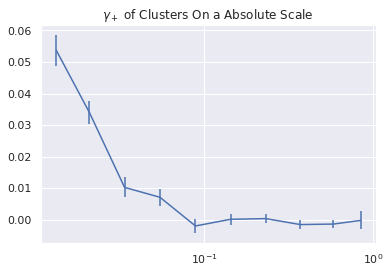

Aggregated xi:
[-29.0869 -37.1669 -17.4546 -19.7759   8.8524  -1.0438  -3.9795  21.3482
  16.7836   0.5341]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2339.7683  -4225.4973  -5762.9318  -8055.5608 -10923.8734 -14049.2476
 -15867.7848 -13899.7473  -6648.0985   -431.7922]
------------------------------------------------------------------------------
Aggregated npairs:
[  542.  1093.  1702.  2774.  4515.  7236. 10852. 14040. 12336.  2581.]
------------------------------------------------------------------------------
Mean xi:
[-0.0537 -0.034  -0.0103 -0.0071  0.002  -0.0001 -0.0004  0.0015  0.0014
  0.0002]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3169 -3.866  -3.386  -2.904  -2.4195 -1.9416 -1.4622 -0.99   -0.5389
 -0.1673]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

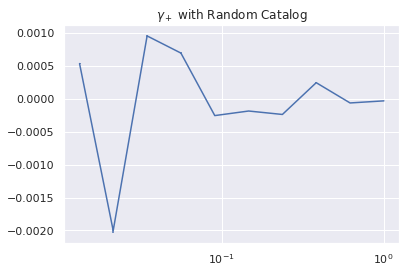

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3424e-06  3.1058e-05 -1.4862e-05 -1.0815e-05  3.9322e-06  2.8539e-06
  3.6650e-06 -3.8305e-06  9.5114e-07  4.5641e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

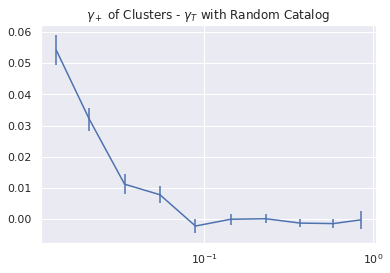

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

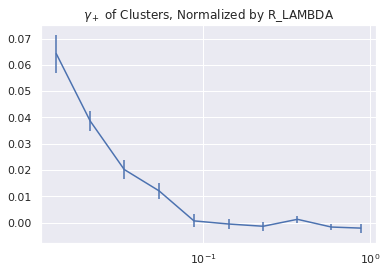

Aggregated xi:
[-17.9156 -32.5685 -27.1629 -26.6285  -2.3603   2.9441  12.0163 -16.2176
  24.3804  15.9425]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1208.2312  -3253.3502  -4558.3977  -6418.4636  -8367.6825 -11202.5761
 -13017.156  -12765.1839  -7855.7628  -1015.8311]
------------------------------------------------------------------------------
Aggregated npairs:
[  279.   842.  1343.  2204.  3441.  5737.  8817. 12713. 14675.  7720.]
------------------------------------------------------------------------------
Mean xi:
[-0.0642 -0.0387 -0.0202 -0.0121 -0.0007  0.0005  0.0014 -0.0013  0.0017
  0.0021]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3306 -3.8638 -3.3942 -2.9122 -2.4318 -1.9527 -1.4764 -1.0041 -0.5353
 -0.1316]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)